### Corrective RAG

In [1]:
from langchain.chat_models import init_chat_model
from langchain.embeddings import init_embeddings

from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage, HumanMessage, AnyMessage
from langchain_core.output_parsers import StrOutputParser

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS

from langchain_tavily import TavilySearch
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langgraph.prebuilt import ToolNode, tools_condition

from langsmith import Client

from typing import Annotated, TypedDict, Literal
from pydantic import BaseModel, Field
from dotenv import load_dotenv

import os

load_dotenv()

/Users/srinivas/Documents/Others/My_projects/Python/DSAIML/agenticai/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


True

### Model and Embedding initialization

In [2]:
# set the project name for tracing
os.environ["LANGCHAIN_PROJECT"] = "Agentic Corrective RAG"

In [3]:
model = init_chat_model(
    model="gpt-4.1-mini", 
    model_provider="openai",
    temperature=0.7,
)

embeddings = init_embeddings("openai:text-embedding-3-small")

### Load, extract and flatten documents from Web

In [4]:
#  Load and extract docs from SmolAgents docs

urls = [
    "https://huggingface.co/docs/smolagents/index",
    "https://huggingface.co/docs/smolagents/installation",
    "https://huggingface.co/docs/smolagents/guided_tour",
    "https://huggingface.co/docs/smolagents/tutorials/building_good_agents",
    "https://huggingface.co/docs/smolagents/tutorials/inspect_runs",
    "https://huggingface.co/docs/smolagents/tutorials/tools"
]

# load the docs from the urls 
docs = [WebBaseLoader(url).load() for url in urls]
docs

# extract the inner list from docs and flatten it 
flat_doc_list = [doc for sublist in docs for doc in sublist]

### Text Splitter, Document Store (Vector Store) and Retriever (Setup)

In [5]:
# Set up text splitter - recursive character based with chunk size of 1000 and chunk overlap of 100
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

In [6]:
doc_chunks = text_splitter.split_documents(flat_doc_list)
doc_chunks

vectorstore_faiss = FAISS.from_documents(doc_chunks, embeddings)
retriever = vectorstore_faiss.as_retriever()

# print(retriever_lg.invoke("How to build agents?"))

### Setup Retriever as a tool

In [7]:
@tool
def retriever_samolagents_vector_db_blog(query: str) -> str:
    """Search and extract documents about SmolAgents"""
    docs = retriever.invoke(query)
    return "\n\n".join([doc.page_content for doc in docs])

retriever_smolagents_tool = retriever_samolagents_vector_db_blog

In [8]:
# Adding search tool
tavily_srearch_tool = TavilySearch()

In [9]:
tools = [retriever_smolagents_tool, tavily_srearch_tool]

### Status Till Now:

- Extracted documents from web about LangGraph
- It has information about LangGraph Implementation
- Used FAISS vectorstore to save the document and chunking them
- Created vectorstore as retriever
- Created retriever tool


### Bind the Model with tools

In [10]:
model_with_tools = model.bind_tools(tools=tools)

### Build Graph

Step 1: Create an Agent that will use model with tools to get relavent documents based on query

In [11]:
class AgentState(TypedDict):
    # add_messages is a reducer function, that defines how to add messages to the list
    # by default state would replace the entry, but with add_messages it would append to the list
    question: str
    answer: str
    web_search: str
    docs: str

In [12]:
def agent_node(state: AgentState) -> AgentState:
    """ 
    Invokes the agent model to generate a response based on current state. Given the
    question, it will decide to call the retriever tool or end the call"""

    system = "You are an assistant that will extract relevant documents"

    human = """Here is the question: \n{question}\n
    """
    
    prompt = ChatPromptTemplate.from_messages([("system", system), ("human", human)])

    chain = prompt | model_with_tools

    question = state["question"]

    response = chain.invoke({"question": question})

     # Check if there are tool calls
    if response.tool_calls:
        # Create a mapping of tool names to tool functions
        tools_by_name = {tool.name: tool for tool in tools}
        
        # Execute each tool call
        tool_results = []
        for tool_call in response.tool_calls:
            tool = tools_by_name[tool_call["name"]]
            result = tool.invoke(tool_call["args"])
            tool_results.append(result)
        
        return {"docs": tool_results}
    return {"docs": ""}

### Next Steps

In [13]:
# Add Structured Schema for Grading
class GradeSchema(BaseModel):
    """Binary score for relevance check"""
    binary_score: Literal["yes", "no"] = Field(description="Binary score for relevance check, with yes or no")

# Now update the Model with this schema so that we can get only binary score
model_with_schema = model.with_structured_output(GradeSchema)

In [14]:
def grade_docs_node(state: AgentState) -> AgentState:
    """
    Determines whether the retrieved docs are good enough to answer the question. 
    If yes, generate the answer.
    If not, rewrite the question.
    """

    system = "You are an assistant that will assess the relevance of retrieved docs to answer a question."

    human = """Here is the retrieved docs: \n{retrieved_docs}\n

    Question: \n{question}\n

    If the retrieved docs are relevant keyword(s) and symantic meaning related to the question asked, 
    then grade with 'yes'. Otherwise, answer with 'no'.
    """

    prompt = ChatPromptTemplate.from_messages([("system", system), ("human", human)])

    chain = prompt | model_with_schema

    question = state["question"]
    retrieved_docs = state["docs"]

    response = chain.invoke({"retrieved_docs": retrieved_docs, "question": question})
    score = response.binary_score

    if score == "yes":
        print(f"Docs are good enough to answer the question, score: {score}, verdict: generate")
        return {"web_search": "no"}
    else:
        print(f"Docs are not good enough to answer the question, score: {score}, verdict: rewrite")
        return {"web_search": "yes"}

In [15]:
def generate_answer_node(state: AgentState) -> AgentState:

    client = Client()
    prompt = client.pull_prompt("rlm/rag-prompt")
    
    question = state["question"]
    retrieved_docs = state["docs"]

    parser = StrOutputParser()

    rag_chain = prompt | model | parser

    answer = rag_chain.invoke({"context": retrieved_docs, "question": question})

    return {"answer": answer}

In [16]:
def rewrite_question_node(state: AgentState) -> AgentState:

    system = "You are an assistant that will rewrite the question based on the conext."

    human = """Here is the question: \n{question}\n
    Update the question to be more specific and clear based on the context.
    """
    
    prompt = ChatPromptTemplate.from_messages([("system", system), ("human", human)])
    parser = StrOutputParser()

    chain = prompt | model | parser

    question = state["question"]

    rewritten_question = chain.invoke({"question": question})

    return {"question": rewritten_question}

In [17]:
def ask_web_node(state: AgentState) -> AgentState:
    system = "You are an assistant that ask the web to extract relavent information."

    human = """Here is the question: \n{question}\n
    """
    
    prompt = ChatPromptTemplate.from_messages([("system", system), ("human", human)])
    parser = StrOutputParser()

    chain = prompt | model_with_tools | parser

    question = state["question"]

    relavent_info = chain.invoke({"question": question})

    return {"docs": relavent_info}

In [18]:
def decide_route(state: AgentState) -> Literal["generate", "rewrite_question"]:

    if state["web_search"] == "no":
        return "generate"
    else:
        return "rewrite_question"

### Create a State Graph

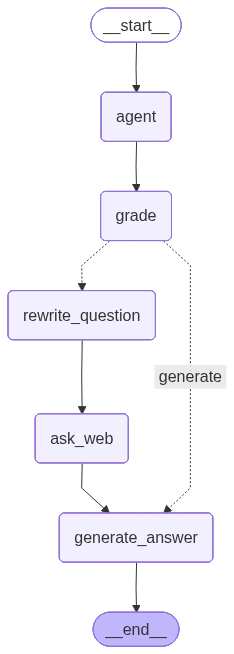

In [19]:
graph = StateGraph(AgentState)

graph.add_node("agent", agent_node)
graph.add_node("grade", grade_docs_node)
graph.add_node("generate_answer", generate_answer_node)
graph.add_node("rewrite_question", rewrite_question_node)
graph.add_node("ask_web", ask_web_node)


graph.add_edge(START, "agent")

graph.add_edge("agent", "grade")
graph.add_conditional_edges("grade", decide_route, {"generate": "generate_answer", "rewrite_question": "rewrite_question"})
graph.add_edge("rewrite_question", "ask_web")
graph.add_edge("ask_web", "generate_answer")
graph.add_edge("generate_answer", END)

workflow = graph.compile()
workflow

In [20]:
initial_state = {"question": "What is Machine Learning?"}

output = workflow.invoke(initial_state)

output["answer"]

Docs are good enough to answer the question, score: yes, verdict: generate


'Machine learning is a branch of artificial intelligence that uses algorithms trained on data to create models capable of making predictions or classifying information without human intervention. It enables software to uncover hidden patterns within datasets and perform tasks such as image recognition, data analysis, and prediction. Essentially, machine learning trains models to apply learned patterns to new data for accurate decision-making.'

In [21]:
initial_state = {"question": "What is smolagents?"}

output = workflow.invoke(initial_state)

output["answer"]

Docs are good enough to answer the question, score: yes, verdict: generate


'Smolagents is an open-source Python library that simplifies building and running agents with minimal code. It supports CodeAgents, which write actions in code for tool invocation and computations, and ToolCallingAgents for JSON/text-based tool-calling. The library is model-agnostic and integrates with platforms like Hugging Face Hub and Gradio Spaces.'